**Classifier by Gabrielillo**

## ESPACIO PARA IMPORTAR LAS LIBRERÍAS

In [ ]:
#Importamos las librerías básicas de python que nos hacen falta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
import os
import math
import glob
from PIL import *
from glob import glob
from dataclasses import dataclass

In [ ]:
#Actualizamos el fastai del colab que daba error si no :)
!pip install torch torchvision torchaudio
! [ -e /content ] && pip install -Uqq fastai
!pip install -Uqq fastbook

     |████████████████████████████████| 1.9 MB 8.1 MB/s 
     |████████████████████████████████| 188 kB 7.8 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 720 kB 8.3 MB/s 
     |████████████████████████████████| 46 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 52.8 MB/s 
     |████████████████████████████████| 51 kB 377 kB/s 


In [ ]:
#Importamos de fastai lo que nos haga falta
import fastbook
from fastai import *
from fastbook import *
from fastai.vision import *
from fastai.basics import *
from fastai.imports import *
from fastai.data.external import *

In [ ]:
#Entramos en la cuenta de drive para poder cargar las imágenes desde allí
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ESPACIO PARA LEER LOS DATOS

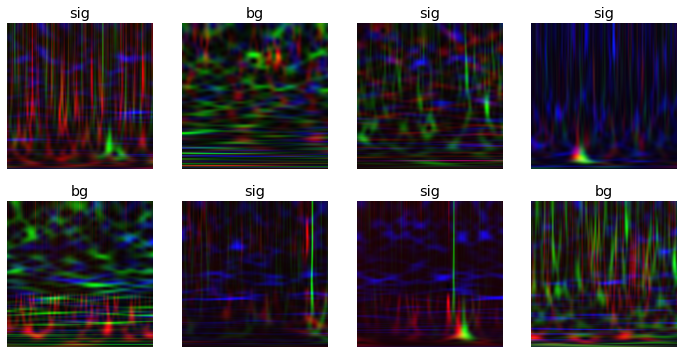

In [ ]:
#Creamos el path desde drive y el data
path = Path('/content/drive/MyDrive/ENTRENEINVESTIGA/imagenes20k')
data = ImageDataLoaders.from_folder(path, valid_pct=0.15, bs=8)
data.show_batch()

## ESPACIO PARA EL ALGORITMO DE LA IA

In [ ]:
#This sometimes helps with persistent Cuda Out Of Memory errors. I think. Could be placebo (ya estaba no lo toco)
import torch, gc
gc.collect()
torch.cuda.empty_cache()
#Realizamos el cnn_learner
learn = cnn_learner(data, models.resnet101, pretrained = True, metrics = [accuracy, error_rate]) #, opt_func = optim.SGD de momento no haremos optimización que da error


In [ ]:
@dataclass
class wd_finder:
    learn: Learner
    wd:Union[int, callable] = None    #LA C EN MINÚSCULA

    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0,1e-1,1e-3,1e-5]
#           self.wd_list = [1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(**kwargs)                     #He quitado wd
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='WD={}'.format(self.wd_list[k]))
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.set_xscale('log')

In [ ]:
learn.to_fp16() 

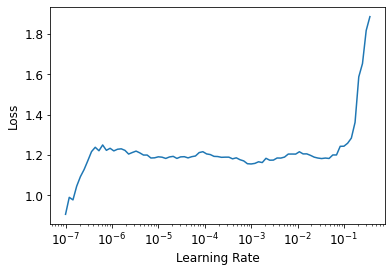

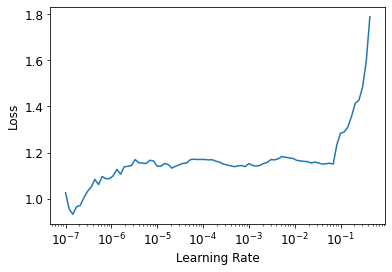

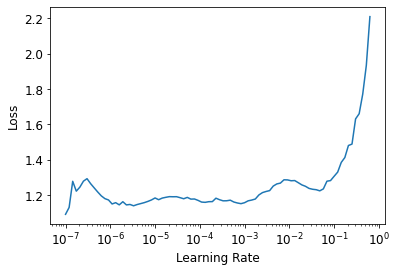

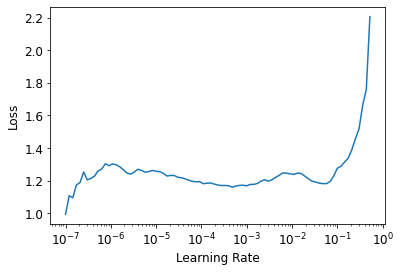

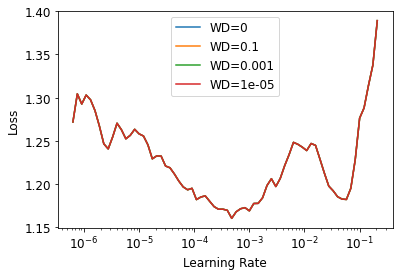

In [ ]:
#Esto imagino sirve para saber cual es el wd óptimo para aligerar el aprendizaje
find_wd = wd_finder(learn)
find_wd.plot_wd(skip_end=10,skip_start=10)

#ESPACIO PARA ENTRENAR LA IA

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.00010964782268274575)

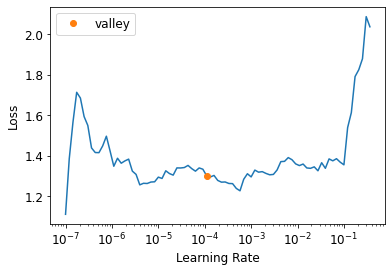

In [ ]:
learn = cnn_learner(data, models.resnet101, pretrained = True, metrics = [accuracy, error_rate])
learn.lr_find()

FlattenedLoss of CrossEntropyLoss()

In [ ]:
#Aquí entrenamos la IA por fin, hay tan pocos tiempos porque ya se entreno anteriormente y se guardaron los pesos
learn.unfreeze()
learn.fit_one_cycle(7, 0.00010964782268274575,cbs=[SaveModelCallback(monitor='accuracy', fname='resnet101')])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.841103,0.940960,0.717667,0.282333,52:32
1,0.686420,1.918450,0.737667,0.262333,09:33
2,0.668102,0.589076,0.743667,0.256333,09:30
3,0.492253,0.413968,0.807000,0.193000,09:30
4,0.528937,0.722230,0.763333,0.236667,09:30
5,0.482871,9.024364,0.737000,0.263000,09:30
6,0.483203,4.985437,0.751667,0.248333,09:29


Better model found at epoch 0 with accuracy value: 0.7176666855812073.
Better model found at epoch 1 with accuracy value: 0.737666666507721.
Better model found at epoch 2 with accuracy value: 0.7436666488647461.
Better model found at epoch 3 with accuracy value: 0.8069999814033508.


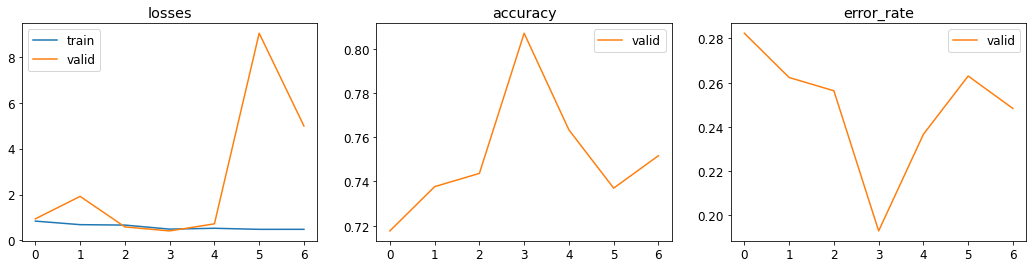

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
learn.recorder.plot_metrics()

In [ ]:
#Aquí guardo los pesos por si acaso
learn.save('/content/drive/MyDrive/pesos20inv')

#ESPACIO PARA LA VALIDACIÓN

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#Aquí hacemos el thres, teniendo claro que es sigmoide y pues toma los valores mayores del 55%
thres=0.5
interp.pred_class=(interp.preds[:,1]>thres)*1

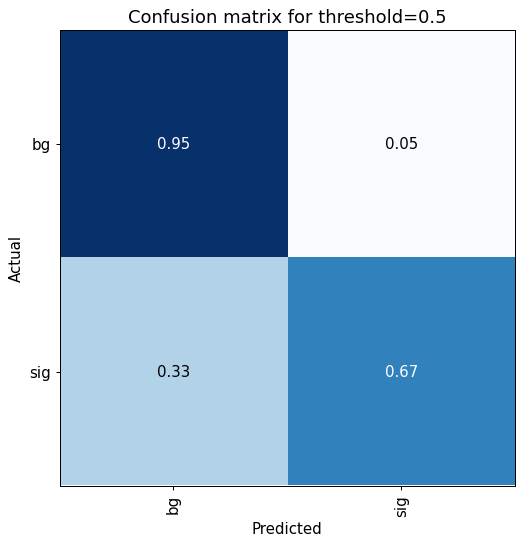

In [ ]:
#Hacemos la confusion matrix para ver que tal hemos entrenado a la IA
interp.plot_confusion_matrix(normalize=True,figsize=(6,6),cmap='Blues', facecolor='w', title=f'Confusion matrix for threshold={thres}',dpi=90)

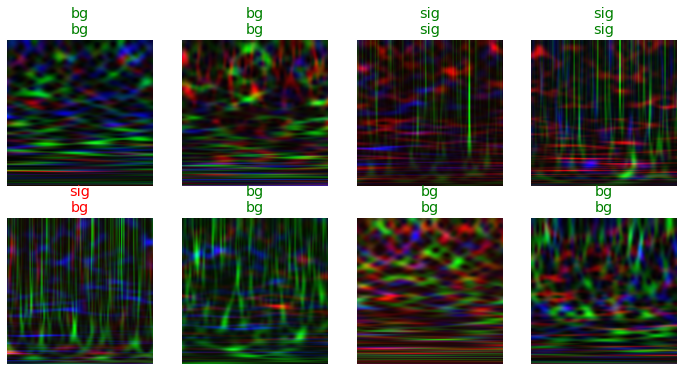

In [ ]:
#Vemos a ver que tal de manera chula hemos entrenado a la IA con ejemplitos
learn.show_results(max_n=24)

In [ ]:
#Aquí vamos a hacer inferencia de 200 fotos generadas nuevas para ver que tal infiere la IA
impaths = glob('/content/drive/MyDrive/dist40/sig/*.png')
pred_array=[]
print(impaths)
t = 0
k = 0
for impath in impaths:
    prediction, pred, probs=learn.predict(impath)
    '''if impath[38:41] == 'sig':
      solution = 'sig'
      num = int(impath[42:44])
    else:
      solution = 'bg'
      num = int(impath[41:43])'''
    solution = "sig"

    if prediction == 'sig':
      error = float(probs[0])
    else:
      error = float(probs[1])
    
    k = k+1
   # if np.float16(probs[1])<0.5:  #esto es por si hay incertidubre de si es ruido o es señal tomar siempre como ruido
    #    prediction='bg'
    if solution == prediction:
      succes = 'Yes'
      t = t+1
    else:
      succes = 'No'
    pred_array.append((solution, prediction, round(error, 3), succes))
#Lo que hacemos aquí en realidad es recorrer todo el directorio e ir haciendo learn.predict foto por foto, guardando en un...
#...vector la etiqueta de la foto, la predicción, el error en la predicción y si ha acertado o no la predicción

In [ ]:
#Con los datos anteriores creamos una tablita muy chula donde nos dice la prediccion, el error en la prediccion y si ha fallado o no la predicción
import prettytable as ptt
x=ptt.PrettyTable()
x.add_column('GW',np.array(pred_array)[:,0])
x.add_column('Prediction',np.array(pred_array)[:,1])
x.add_column('Score',np.array(pred_array)[:,2])
x.add_column('Success',np.array(pred_array)[:,3])
print('Porcentaje de aciertos = ', round((t/k)*100, 3), '%')
print(x.get_string(sortby="Score", reversesort=True))

Porcentaje de aciertos =  25.0 %
+-----+------------+-------+---------+
|  GW | Prediction | Score | Success |
+-----+------------+-------+---------+
| sig |     bg     | 0.495 |    No   |
| sig |     bg     | 0.494 |    No   |
| sig |    sig     | 0.492 |   Yes   |
| sig |     bg     | 0.492 |    No   |
| sig |     bg     | 0.491 |    No   |
| sig |     bg     | 0.491 |    No   |
| sig |     bg     |  0.49 |    No   |
| sig |     bg     | 0.487 |    No   |
| sig |     bg     | 0.487 |    No   |
| sig |    sig     | 0.486 |   Yes   |
| sig |    sig     | 0.485 |   Yes   |
| sig |     bg     | 0.485 |    No   |
| sig |     bg     | 0.484 |    No   |
| sig |     bg     | 0.482 |    No   |
| sig |    sig     | 0.481 |   Yes   |
| sig |     bg     |  0.48 |    No   |
| sig |    sig     | 0.479 |   Yes   |
| sig |     bg     | 0.479 |    No   |
| sig |    sig     | 0.477 |   Yes   |
| sig |    sig     | 0.476 |   Yes   |
| sig |     bg     | 0.476 |    No   |
| sig |    sig     | 0.474 |   